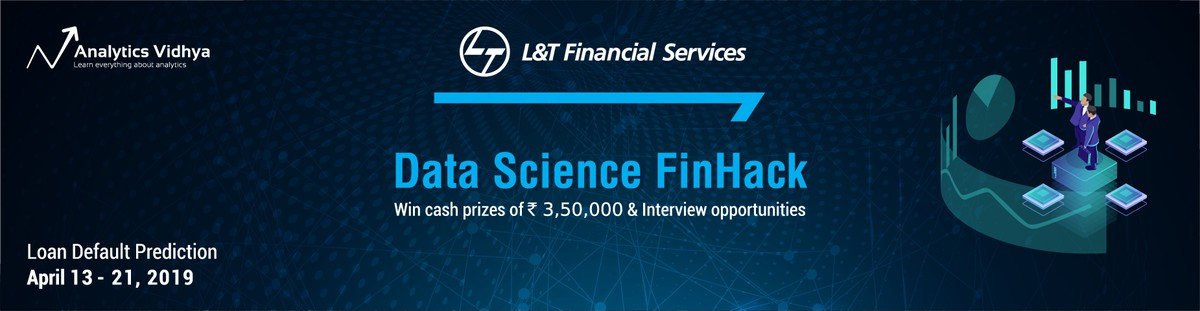

# LTFS Data Science FinHack ( ML Hackathon)

## L&T Financial Services & Analytics Vidhya presents ‘DataScience FinHack’.

In this FinHack, you will develop a model for our most common but real challenge ‘Loan Default Prediction’ & also, get a feel of our business!


If your solution adds good value to our organization, take it from us, Sky is the limit for you!

## Problem Statement

### Vehicle Loan Default Prediction

Financial institutions incur significant losses due to the default of vehicle loans. This has led to the tightening up of vehicle loan underwriting and increased vehicle loan rejection rates. The need for a better credit risk scoring model is also raised by these institutions. This warrants a study to estimate the determinants of vehicle loan default. A financial institution has hired you to accurately predict the probability of loanee/borrower defaulting on a vehicle loan in the first EMI (Equated Monthly Instalments) on the due date. Following Information regarding the loan and loanee are provided in the datasets:


 >1.Loanee Information (Demographic data like age, income, Identity proof etc.)
 
 >2.Loan Information (Disbursal details, amount, EMI, loan to value ratio etc.)
 
 >3.Bureau data & history (Bureau score, number of active accounts, the status of other loans, credit history etc.)

Doing so will ensure that clients capable of repayment are not rejected and important determinants can be identified which can be further used for minimising the default rates.

### Data Description

>train.zip contains train.csv and data_dictionary.csv.

>train.csv contains the training data with details on loan as described in the last section

>data_dictionary.csv contains a brief description on each variable provided in the training and test set.

>test.csv contains details of all customers and loans for which the participants are to submit probability of default.

>sample_submission.csv contains the submission format for the predictions against the test set. A single csv needs to be submitted as a solution.

### Evaluation Metric

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### Public and Private Split

Test data is further randomly divided into Public (25%) and Private (75%) data. Your initial responses will be checked and scored on the Public data. The final rankings would be based on your private score which will be published once the competition is over.

### Importing Tools:

In [7]:
import pandas as pd
import numpy as np
from pprint import pprint
from datetime import datetime, timedelta
from sklearn_pandas import CategoricalImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, auc, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from xgboost.sklearn import XGBClassifier

## Reading & Understanding the Data

In [8]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test_bqCt9Pv.csv")

In [9]:
data_tmp=pd.read_csv("train.csv")
test_tmp = pd.read_csv("test_bqCt9Pv.csv")

In [10]:
data.describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,...,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,233154.000000,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,...,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000
mean,535917.573376,54356.993528,7.586507e+04,74.746530,72.936094,19638.635035,69.028054,3396.880247,7.262243,1549.477148,...,0.007244,5.427793e+03,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,0.217071
std,68315.693711,12971.314171,1.894478e+04,11.456636,69.834995,3491.949566,22.141304,2238.147502,4.482230,975.261278,...,0.111079,1.702370e+05,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,0.412252
min,417428.000000,13320.000000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,...,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,476786.250000,47145.000000,6.571700e+04,68.880000,14.000000,16535.000000,48.000000,1511.000000,4.000000,713.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,535978.500000,53803.000000,7.094600e+04,76.800000,61.000000,20333.000000,86.000000,2970.000000,6.000000,1451.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,595039.750000,60413.000000,7.920175e+04,83.670000,130.000000,23000.000000,86.000000,5677.000000,10.000000,2362.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,671084.000000,990572.000000,1.628992e+06,95.000000,261.000000,24803.000000,156.000000,7345.000000,22.000000,3795.000000,...,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,1.000000


In [12]:
data.dtypes

UniqueID                                 int64
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
supplier_id                              int64
manufacturer_id                          int64
Current_pincode_ID                       int64
Date.of.Birth                           object
Employment.Type                         object
DisbursalDate                           object
State_ID                                 int64
Employee_code_ID                         int64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACC

In [13]:
# Inspecting the data
# This tells us the datatypes, No of Levels of the variables

def inspect_data(x):

    return pd.DataFrame({"Data Type":x.dtypes,"No of Levels":x.apply(lambda x: x.unique().shape[0],axis=0), "Levels":x.apply(lambda x: str(x.unique()),axis=0)})
inspect_data(data)

,Data Type,No of Levels,Levels
UniqueID,int64,233154,[420825 537409 417566 ... 613658 548084 630213]
disbursed_amount,int64,24565,[50578 47145 53278 ... 61456 51406 34259]
asset_cost,int64,46252,[58400 65550 61360 ... 45233 52965 116009]
ltv,float64,6579,[89.55 73.23 89.63 ... 33.32 32.53 33.82]
branch_id,int64,82,[67 78 34 130 74 11 5 20 63 48 79 3 42 142 36 ...
supplier_id,int64,2953,[22807 22744 17014 ... 23618 22289 24031]
manufacturer_id,int64,11,[45 86 48 51 120 49 145 67 153 156 152]
Current_pincode_ID,int64,6698,[1441 1502 1497 ... 3586 680 693]
Date.of.Birth,object,15433,['01-01-84' '31-07-85' '24-08-85' ... '24-03-6...
Employment.Type,object,3,['Salaried' 'Self employed' nan]


## Feature Engineering:

In [4]:
## Extracting age from the column date of birth
data["presentday"] = pd.datetime.now().strftime("%d-%m-%y")
test["presentday"] = pd.datetime.now().strftime("%d-%m-%y")
data["presentday"] = pd.to_datetime(data["presentday"])
test["presentday"] = pd.to_datetime(test["presentday"])
data['Date.of.Birth'] = [datetime.strptime(x, '%d-%m-%y') for x in data['Date.of.Birth']]
test['Date.of.Birth'] = [datetime.strptime(x, '%d-%m-%y') for x in test['Date.of.Birth']]
data["Age"] = data["presentday"] - data['Date.of.Birth']
test["Age"] = test["presentday"] - test['Date.of.Birth']
data["Age"] = data["Age"] / np.timedelta64(1, 'Y')
test["Age"] = test["Age"] / np.timedelta64(1, 'Y')
data.drop(['Date.of.Birth','presentday'],axis=1,inplace=True)
test.drop(['Date.of.Birth','presentday'],axis=1,inplace=True)
data.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,DisbursalDate,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Age
0,420825,50578,58400,89.55,67,22807,45,1441,Salaried,03-08-18,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,35.847416
1,537409,47145,65550,73.23,67,22807,45,1502,Self employed,26-09-18,...,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,34.267644
2,417566,53278,61360,89.63,67,22807,45,1497,Self employed,01-08-18,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,34.201934
3,624493,57513,66113,88.48,67,22807,45,1501,Self employed,26-10-18,...,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,25.851318
4,539055,52378,60300,88.39,67,22807,45,1495,Self employed,26-09-18,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,41.909143


In [5]:
## Extracting time period after disbursal  from the date of amount disbusal.
data["presentday"] = pd.datetime.now().strftime("%d-%m-%y")
test["presentday"] = pd.datetime.now().strftime("%d-%m-%y")
data["presentday"] = pd.to_datetime(data["presentday"])
test["presentday"] = pd.to_datetime(test["presentday"])
data['DisbursalDate'] = [datetime.strptime(x, '%d-%m-%y') for x in data['DisbursalDate']]
test['DisbursalDate'] = [datetime.strptime(x, '%d-%m-%y') for x in test['DisbursalDate']]
data["PeriodAfterDisbursal"] = data["presentday"] - data['DisbursalDate']
test["PeriodAfterDisbursal"] = test["presentday"] - test['DisbursalDate']
data["PeriodAfterDisbursal"] = data["PeriodAfterDisbursal"] / np.timedelta64(1, 'Y')
test["PeriodAfterDisbursal"] = test["PeriodAfterDisbursal"] / np.timedelta64(1, 'Y')
data.drop(['DisbursalDate','presentday'],axis=1,inplace=True)
test.drop(['DisbursalDate','presentday'],axis=1,inplace=True)
data.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,...,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Age,PeriodAfterDisbursal
0,420825,50578,58400,89.55,67,22807,45,1441,Salaried,6,...,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,35.847416,1.259437
1,537409,47145,65550,73.23,67,22807,45,1502,Self employed,6,...,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,34.267644,1.111590
2,417566,53278,61360,89.63,67,22807,45,1497,Self employed,6,...,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,34.201934,1.264913
3,624493,57513,66113,88.48,67,22807,45,1501,Self employed,6,...,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,25.851318,1.029453
4,539055,52378,60300,88.39,67,22807,45,1495,Self employed,6,...,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,41.909143,1.111590


In [ ]:
# Creating new feature for average account age. Removing the strings the column
new = data["AVERAGE.ACCT.AGE"].str.split(" ", n = 1, expand = True)
new1 = test["AVERAGE.ACCT.AGE"].str.split(" ", n = 1, expand = True)
data["AverageYear"] = new[0]
data["AverageMonth"] = new[1]
test["AverageYear"] = new1[0]
test["AverageMonth"] = new1[1]
data["AverageYear"] = data["AverageYear"].str.extract('(\d+)')
data["AverageMonth"] = data["AverageMonth"].str.extract('(\d+)')
test["AverageYear"] = test["AverageYear"].str.extract('(\d+)')
test["AverageMonth"] = test["AverageMonth"].str.extract('(\d+)')
data["AverageYear"] = data["AverageYear"].astype("int")
data["AverageMonth"] = data["AverageMonth"].astype("int")
test["AverageYear"] = test["AverageYear"].astype("int")
test["AverageMonth"] = test["AverageMonth"].astype("int")
data["AverageMonth"] = data["AverageMonth"] / (12)
test["AverageMonth"] = test["AverageMonth"] / (12)
data["AVERAGE.ACCT.AGE"] = data["AverageYear"] + data["AverageMonth"]
test["AVERAGE.ACCT.AGE"] = test["AverageYear"] + test["AverageMonth"]
data.drop(['AverageYear','AverageMonth'], axis=1, inplace=True)
test.drop(['AverageYear','AverageMonth'], axis=1, inplace=True)

In [ ]:
# Creating new feature for Credit History Length by removing strings in the column
new = data["CREDIT.HISTORY.LENGTH"].str.split(" ", n = 1, expand = True)
new1 = test["CREDIT.HISTORY.LENGTH"].str.split(" ", n = 1, expand = True)
data["CreditYear"] = new[0]
data["CreditMonth"] = new[1]
test["CreditYear"] = new1[0]
test["CreditMonth"] = new1[1]
data["CreditYear"] = data["CreditYear"].str.extract('(\d+)')
data["CreditMonth"] = data["CreditMonth"].str.extract('(\d+)')
test["CreditYear"] = test["CreditYear"].str.extract('(\d+)')
test["CreditMonth"] = test["CreditMonth"].str.extract('(\d+)')
data["CreditYear"] = data["CreditYear"].astype("int")
data["CreditMonth"] = data["CreditMonth"].astype("int")
test["CreditYear"] = test["CreditYear"].astype("int")
test["CreditMonth"] = test["CreditMonth"].astype("int")
data["CreditMonth"] = data["CreditMonth"] / (12)
test["CreditMonth"] = test["CreditMonth"] / (12)
data["CREDIT.HISTORY.LENGTH"] = data["CreditYear"] + data["CreditMonth"]
test["CREDIT.HISTORY.LENGTH"] = test["CreditYear"] + test["CreditMonth"]
data.drop(['CreditYear','CreditMonth'], axis=1, inplace=True)
test.drop(['CreditYear','CreditMonth'], axis=1, inplace=True)

In [ ]:
## Creating new column yet to be disbursed amount
data["YetToBeDisbursed"] = data["PRI.SANCTIONED.AMOUNT"] - data["PRI.DISBURSED.AMOUNT"]
test["YetToBeDisbursed"] = test["PRI.SANCTIONED.AMOUNT"] - test["PRI.DISBURSED.AMOUNT"]

## Data Cleansing:

In [62]:
## Imputing missing data in employment type with mode
# !pip install sklearn-pandas

In [63]:
data["Employment.Type"]= data["Employment.Type"].astype("category")
test["Employment.Type"]= test["Employment.Type"].astype("category")

In [64]:
mode_imputer = CategoricalImputer(strategy='most_frequent')
mode_imputer.fit(data["Employment.Type"])
data["Employment.Type"] = mode_imputer.transform(data["Employment.Type"])
test["Employment.Type"] = mode_imputer.transform(test["Employment.Type"])

In [67]:
print(data.shape)
print(test.shape)

(233154, 41)
(112392, 40)


In [69]:
data.drop(['UniqueID',], axis=1, inplace=True)
test.drop(['UniqueID'], axis=1, inplace=True)

In [72]:
# Dropping MobileNo_Avl_Flag as well as it is constant
data.drop(['MobileNo_Avl_Flag','SEC.NO.OF.ACCTS','SEC.INSTAL.AMT','SEC.ACTIVE.ACCTS','SEC.OVERDUE.ACCTS','Driving_flag',
          'Passport_flag','SEC.DISBURSED.AMOUNT','SEC.SANCTIONED.AMOUNT','SEC.CURRENT.BALANCE'], axis=1, inplace=True)
test.drop(['MobileNo_Avl_Flag','SEC.NO.OF.ACCTS','SEC.INSTAL.AMT','SEC.ACTIVE.ACCTS','SEC.OVERDUE.ACCTS','Driving_flag',
          'Passport_flag','SEC.DISBURSED.AMOUNT','SEC.SANCTIONED.AMOUNT','SEC.CURRENT.BALANCE'], axis=1, inplace=True)

In [73]:
#Dropping PERFORM_CNS.SCORE.DESCRIPTION as well as CNS score is already given and this is just a description of that score
data.drop(['PERFORM_CNS.SCORE.DESCRIPTION'], axis=1, inplace=True)
test.drop(['PERFORM_CNS.SCORE.DESCRIPTION'], axis=1, inplace=True)

In [74]:
# creating dummies
data = pd.get_dummies(data, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [ ]:
print(data.shape)
print(test.shape)

In [75]:
# Splitting data into train and test

In [76]:
train,test1 = train_test_split(data,test_size = 0.3, random_state = 100)
# Decoupling target from train

y_train = train['loan_default']
X_train = train.copy().drop('loan_default', axis=1)
y_test = test1['loan_default']
X_test = test1.copy().drop('loan_default', axis=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

## Logistic - Tune

In [ ]:
score_metric = make_scorer(roc_auc_score)

## n_jobs = -1 uses all cores of processor
## max_features is the maximum number of attributes to select for each tree
logit = LogisticRegression(class_weight='balanced',n_jobs=4)
 
# Use a grid over parameters of interest
## n_estimators is the number of trees in the forest
## max_depth is how deep each tree can be
## min_sample_leaf is the minimum samples required in each leaf node for the root node to split
## "A node will only be split if in each of it's leaf nodes there should be min_sample_leaf"

param_grid = {'C':[0.05, 0.075, 0.1, 0.25, 1, 5, 10]}
 
logit_grid = GridSearchCV(estimator = logit, param_grid = param_grid, cv = 3, scoring=score_metric, n_jobs=4, verbose=1)
logit_grid.fit(X_train, y_train)
logit_grid.best_estimator_

## Logistic - Final

In [77]:
logit_final = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100, n_jobs=4, penalty='l2', random_state=None, tol=0.0001, verbose=0, warm_start=False)

logit_final.fit(X_train, y_train)

train_pred = logit_final.predict(X_train)
test_pred = logit_final.predict(X_test)

print("Train")
print(accuracy_score(y_train,train_pred))
print(confusion_matrix(y_train,train_pred))
print(classification_report(y_train,train_pred))
print(roc_auc_score(y_train, train_pred))

print("Test")
print(accuracy_score(y_test,test_pred))
print(confusion_matrix(y_test,test_pred))
print(classification_report(y_test,test_pred))
print(roc_auc_score(y_train, train_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


Train
0.539118748749035
[[70188 66705]
 [13887 24085]]
             precision    recall  f1-score   support

          0       0.83      0.51      0.64    136893
          1       0.27      0.63      0.37     37972

avg / total       0.71      0.54      0.58    174865

0.573502385350729
Test
0.5407195182624509
[[23468 22182]
 [ 4589  8050]]
             precision    recall  f1-score   support

          0       0.84      0.51      0.64     45650
          1       0.27      0.64      0.38     12639

avg / total       0.71      0.54      0.58     58289

0.573502385350729


## RF - Tune

In [ ]:
score_metric = make_scorer(roc_auc_score)

## n_jobs = -1 uses all cores of processor
## max_features is the maximum number of attributes to select for each tree
rfc_grid = RandomForestClassifier(n_jobs=4,max_features='sqrt', class_weight='balanced')
 
# Use a grid over parameters of interest
## n_estimators is the number of trees in the forest
## max_depth is how deep each tree can be
## min_sample_leaf is the minimum samples required in each leaf node for the root node to split
## "A node will only be split if in each of it's leaf nodes there should be min_sample_leaf"

param_grid = {"n_estimators" : [100, 200, 300],
              "max_depth" : [10,15,20,25,30,35,40],
              "criterion" : ["gini","entropy"],
             "max_features" : ["sqrt","log2"],
             "min_samples_leaf" : [5, 10, 15, 20]}
 
rfc_cv_grid = RandomizedSearchCV(estimator = rfc_grid, param_distributions = param_grid, cv = 3, n_iter=20, scoring=score_metric, n_jobs=4, verbose=3)
rfc_cv_grid.fit(X_train, y_train)
rfc_cv_grid.best_estimator_

## RF - Final

In [78]:
rfc_final = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

rfc_final.fit(X_train, y_train)

rfc_train_pred = rfc_final.predict(X_train)
rfc_test_pred = rfc_final.predict(X_test)

print("Train")
print(accuracy_score(y_train,rfc_train_pred))
print(confusion_matrix(y_train,rfc_train_pred))
print(classification_report(y_train,rfc_train_pred))
print(roc_auc_score(y_train, rfc_train_pred))

#print("OOB Score", rfc_50.oob_score_)

print("Test")
print(accuracy_score(y_test,rfc_test_pred))
print(confusion_matrix(y_test,rfc_test_pred))
print(classification_report(y_test,rfc_test_pred))
print(roc_auc_score(y_test, rfc_test_pred))

Train
0.6984759671746776
[[94584 42309]
 [10417 27555]]
             precision    recall  f1-score   support

          0       0.90      0.69      0.78    136893
          1       0.39      0.73      0.51     37972

avg / total       0.79      0.70      0.72    174865

0.7083000377124647
Test
0.6350426324006245
[[29841 15809]
 [ 5464  7175]]
             precision    recall  f1-score   support

          0       0.85      0.65      0.74     45650
          1       0.31      0.57      0.40     12639

avg / total       0.73      0.64      0.66     58289

0.6106892225917675


## NB

In [79]:
NBclassifier = GaussianNB()
nb_final = NBclassifier.fit(X_train, y_train)

## Predictions
train_nb_preds = nb_final.predict(X_train)
test_nb_preds = nb_final.predict(X_test)

print("Train Accuracy", nb_final.score(X_train,y_train))
print(confusion_matrix(y_train,train_nb_preds))
print(classification_report(y_train,train_nb_preds))
print(roc_auc_score(y_train, train_nb_preds))

print("Test Accuracy",nb_final.score(X_test,y_test))
print(confusion_matrix(y_test,test_nb_preds))
print(classification_report(y_test,test_nb_preds))
print(roc_auc_score(y_test, test_nb_preds))

Train Accuracy 0.26136162182254885
[[  9028 127865]
 [  1297  36675]]
             precision    recall  f1-score   support

          0       0.87      0.07      0.12    136893
          1       0.22      0.97      0.36     37972

avg / total       0.73      0.26      0.17    174865

0.5158962855018756
Test Accuracy 0.2597574156358833
[[ 2963 42687]
 [  461 12178]]
             precision    recall  f1-score   support

          0       0.87      0.06      0.12     45650
          1       0.22      0.96      0.36     12639

avg / total       0.73      0.26      0.17     58289

0.5142162478539842


## LightGBM - Tune

In [ ]:
num_train, num_feature = X_train.shape

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'class_weight': 'balanced',
}

lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

feature_name = ['feature_' + str(col) for col in range(num_feature)]

print('Starting training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_train,  # eval training data
                learning_rates=lambda iter: 0.1 * (0.99 ** iter),
                early_stopping_rounds= 40,
                feature_name=feature_name)

In [ ]:
final_lgb.predict(X_test)[:10]

In [32]:
#!pip install lightgbm

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Light GBM - Final

In [80]:
final_lgb = lgb.LGBMClassifier(num_leaves=40, n_estimators=50, reg_alpha= 0.2, reg_lambda= 0.6, n_jobs=20, class_weight='balanced')
final_lgb.fit(X_train,y_train)
# gbm_train_pred = np.where(final_lgb.predict(X_train)>0.95,1,0)
# gbm_test_pred = np.where(final_lgb.predict(X_test)>0.95,1,0)

gbm_train_pred = final_lgb.predict(X_train)
gbm_test_pred = final_lgb.predict(X_test)

print("Train")
print(accuracy_score(y_train,gbm_train_pred))
print(confusion_matrix(y_train,gbm_train_pred))
print(classification_report(y_train,gbm_train_pred))
print(roc_auc_score(y_train, gbm_train_pred))


print("Test")
print(accuracy_score(y_test,gbm_test_pred))
print(confusion_matrix(y_test,gbm_test_pred))
print(classification_report(y_test,gbm_test_pred))
print(roc_auc_score(y_test, gbm_test_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train
0.6112772710376576
[[80892 56001]
 [11973 25999]]
             precision    recall  f1-score   support

          0       0.87      0.59      0.70    136893
          1       0.32      0.68      0.43     37972

avg / total       0.75      0.61      0.65    174865

0.6378013947884441
Test
0.5977971830019386
[[26635 19015]
 [ 4429  8210]]
             precision    recall  f1-score   support

          0       0.86      0.58      0.69     45650
          1       0.30      0.65      0.41     12639

avg / total       0.74      0.60      0.63     58289

0.6165189121070087


# Stacking

In [81]:
## Stacking

log_train_pred = logit_final.predict(X_train)
rf_train_pred = rfc_final.predict(X_train)
nb_train_pred = nb_final.predict(X_train)
gbm_train_pred = final_lgb.predict(X_train)

meta_learner_data = pd.DataFrame({"Log Reg":log_train_pred,"RF":rf_train_pred,"NB":nb_train_pred, "GBM":gbm_train_pred})

lr = LogisticRegression(class_weight='balanced')
model7 = lr.fit(meta_learner_data,y_train)

trainpred = model7.predict(meta_learner_data)

## Test Predictions

log_test_pred = logit_final.predict(X_test)
rf_test_pred = rfc_final.predict(X_test)
nb_test_pred = nb_final.predict(X_test)
gbm_test_pred = final_lgb.predict(X_test)

meta_learner_test_data1 = pd.DataFrame({"Log Reg":log_test_pred,"RF":rf_test_pred,"NB":nb_test_pred, "GBM":gbm_test_pred})

preds = model7.predict(meta_learner_test_data1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [47]:
log_test_preds = logit_final.predict(test)
rf_test_preds = rfc_final.predict(test)
nb_test_preds= nb_final.predict(test)
gbm_test_preds = final_lgb.predict(test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
meta_learner_test_data = pd.DataFrame({"Log Reg":log_test_preds,"RF":rf_test_preds,"NB":nb_test_preds, "GBM":gbm_test_preds})

preds1 =model7.predict(meta_learner_test_data)

In [53]:
len(preds1)

112392

In [56]:
pd.DataFrame({"UniqueID":test_tmp['UniqueID'],"loan_default":preds1}).to_csv("Final_pred.csv", index=False)

In [40]:
meta_learner_data.corr()

,Log Reg,RF,NB,GBM
Log Reg,1.000000,0.473603,0.194968,0.449688
RF,0.473603,1.000000,0.151418,0.768768
NB,0.194968,0.151418,1.000000,0.148702
GBM,0.449688,0.768768,0.148702,1.000000


In [82]:
print("Test")
print(accuracy_score(y_test,preds))
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))
print(roc_auc_score(y_test, preds))

print("Train")
print(accuracy_score(y_train,trainpred))
print(confusion_matrix(y_train,trainpred))
print(classification_report(y_train,trainpred))
print(roc_auc_score(y_train, trainpred))

Test
0.6350426324006245
[[29841 15809]
 [ 5464  7175]]
             precision    recall  f1-score   support

          0       0.85      0.65      0.74     45650
          1       0.31      0.57      0.40     12639

avg / total       0.73      0.64      0.66     58289

0.6106892225917675
Train
0.6984759671746776
[[94584 42309]
 [10417 27555]]
             precision    recall  f1-score   support

          0       0.90      0.69      0.78    136893
          1       0.39      0.73      0.51     37972

avg / total       0.79      0.70      0.72    174865

0.7083000377124647


In [ ]:
test_predictions2 = pd.DataFrame({"UniqueID":test_tmp['UniqueID'],"loan_default":lr.predict(test)})
test_predictions2.to_csv("predictions14.csv", index=False)

In [82]:
len(preds)

58289

## Summary:

>Stacking of models gave better results compared to individual models.

>To remove Overfitting, on must check their local score, difference of score in validation set.

>K-Folds cross validation helps curbs overfitting

#### Public LB - 0.602201723255706
#### Private LB - 0.605023201520634